# Online Retail Customer Segmentation

## Description

Many small online retailers and new entrants to the online retail sector are
keen to practice data mining and consumer-centric marketing in their businesses yet
technically lack the necessary knowledge and expertise to do so. In this article a case study of using data mining techniques in customer-centric business intelligence for an online retailer is presented. The main purpose of this analysis is to help the business better understand its customers and therefore conduct customer-centric marketing more effectively. On the basis of the Recency, Frequency, and Monetary model, customers of the business have been segmented into various meaningful groups using the k-medoids,and hierarchical clustering algorithms and the main characteristics of the consumers in each segment have been clearly identified. 

## Dataset

The dataset used is from UCI ML repository [Online Retail](https://archive.ics.uci.edu/dataset/352/online+retail)

Before starting We need to install `scikit-learn-extra` as it provides KMeoids alogrithm

In [1]:
# Installing scikit learn extra as it contains KMedoids Alogrithm
!pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.5 MB/s eta 0:00:00


##  Libraries 

In [2]:
# import required libraries for dataframe and visualization

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px


# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/customer-segmentation-dataset/Online Retail.xlsx


## Load and describing the data

In [3]:
dataset = pd.read_excel('/kaggle/input/customer-segmentation-dataset/Online Retail.xlsx')
dataset.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [4]:
dataset.shape

(541909, 8)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
dataset.describe()

Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303

| Variable Name | Data Type | Description; typical values and meanings                                                  |
| :------------ | :-------- | :---------------------------------------------------------------------------------------- |
| InvoiceNo     | Nominal   | Invoice number; a 6-digit integral number uniquely assigned to each transaction           |
| StockCode     | Nominal   | Product (item) code; a 5-digit integral number uniquely assigned to each distinct product |
| Description   | Nominal   | Product (item) name                                                                       |
| Quantity      | Numeric   | The quantities of each product (item) per transaction                                     |
| InvoiceDate   | Numeric   | The day and time when each transaction was generated; 31 / 05 / 2011 15:59                |
| UnitPrice     | Numeric   | Product price per unit in sterling;  45.23                                                |
| CustomerID    | Nominal   | A unique identifier or code for each customer who made a purchase.                        |
| Country       | Nominal   | Delivery address country; England                                                         |

## Recency Frequency Monetary Segmentation

Before we start cleaning the data, We feel the need to explain the strategy that's going to be used in segmentation

RFM segmentation is a technique that groups customers based on three factors:

1. Recency: How recently a customer made their last purchase.
2. Frequency: How often a customer makes purchases over a given period.
3. Monetary Value: How much money a customer has spent with the company.

Customers are scored and ranked on each of these factors, then segmented into groups like:

- Best Customers: High recency, frequency, and monetary value
- Loyal Customers: High frequency and monetary value, but lower recency
- Recent Customers: High recency, but lower frequency and monetary value
- Lost Customers: Low recency, frequency, and monetary value

This segmentation allows companies to target customers with tailored marketing and retention strategies based on their purchasing behavior and lifetime value.

## Data Cleaning

In [7]:
# Calculating the Missing Values % contribution in DF

df_null = round(100*(dataset.isnull().sum())/len(dataset), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [8]:
# Droping rows having missing values

dataset = dataset.dropna()
dataset.shape

(406829, 8)

In [9]:
# Changing the datatype of Customer Id as per Business understanding

dataset['CustomerID'] = dataset['CustomerID'].astype(str)

## Feature Engineering

### Monetary Attribute

In [10]:
# New Attribute : Monetary

dataset['Monetary'] = dataset['Quantity']*dataset['UnitPrice']
dataset.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  Monetary  
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom     15.30  
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom     20.34  
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom     22.00  
3 2010-12-01 08:26:00       3.39    17850.0  United Kingdom     20.34  
4 2010-12-01 08:26:00       3.39    17850.0  United Kingdom     20.34

In [11]:
# This step groups the data in the dataset DataFrame by the 'CustomerID' column 
# to calculates the sum of the 'Monetary' column for each customer. 
rfm_m = dataset.groupby('CustomerID')['Monetary'].sum().reset_index()
rfm_m.head()

CustomerID  Monetary
0    12346.0      0.00
1    12347.0   4310.00
2    12348.0   1797.24
3    12349.0   1757.55
4    12350.0    334.40

### Frequency Attribute

In [12]:
rfm_f = dataset.groupby('CustomerID')['InvoiceNo'].count().reset_index()
rfm_f.head()

CustomerID  InvoiceNo
0    12346.0          2
1    12347.0        182
2    12348.0         31
3    12349.0         73
4    12350.0         17

In [13]:
rfm_f.columns

Index(['CustomerID', 'InvoiceNo'], dtype='object')

In [14]:
rfm_f.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)
rfm_f.head()

CustomerID  Frequency
0    12346.0          2
1    12347.0        182
2    12348.0         31
3    12349.0         73
4    12350.0         17

In [15]:
# Merging the two dfs

merged_rfm = rfm_m.merge(rfm_f, on='CustomerID')
# another way 
# rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
merged_rfm.head()

CustomerID  Monetary  Frequency
0    12346.0      0.00          2
1    12347.0   4310.00        182
2    12348.0   1797.24         31
3    12349.0   1757.55         73
4    12350.0    334.40         17

### Recency Attribute

In [16]:
# Convert to datetime to proper datatype

dataset['InvoiceDate'] = pd.to_datetime(dataset['InvoiceDate'],format='%d-%m-%Y %H:%M')
dataset.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  Monetary  
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom     15.30  
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom     20.34  
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom     22.00  
3 2010-12-01 08:26:00       3.39    17850.0  United Kingdom     20.34  
4 2010-12-01 08:26:00       3.39    17850.0  United Kingdom     20.34

In [17]:
# Compute the maximum date to know the last transaction date in our dataset

max_date = max(dataset['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [18]:
# calculate the time difference between the maximum date in the dataset and the transaction date for each record

dataset['Diff'] = max_date - dataset['InvoiceDate']
dataset.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  Monetary  \
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom     15.30   
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom     20.34   
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom     22.00   
3 2010-12-01 08:26:00       3.39    17850.0  United Kingdom     20.34   
4 2010-12-01 08:26:00       3.39    17850.0  United Kingdom     20.34   

               Diff  
0 373 days 04:24:00  
1 373 days 04:24:00  
2 373 days 04:24:00  
3 373 days 04:24:00  
4 373 days 04:24:00

In [19]:
# Compute last transaction date to get the recency of customers 
# As each customer may have multiple invonces that has been purshsed 
# So we need to create a indicator that tells us when he made the last transaction to find wather he is active or not
rfm_r = dataset.groupby('CustomerID')['Diff'].min().reset_index()
rfm_r.head()

CustomerID              Diff
0    12346.0 325 days 02:33:00
1    12347.0   1 days 20:58:00
2    12348.0  74 days 23:37:00
3    12349.0  18 days 02:59:00
4    12350.0 309 days 20:49:00

In [20]:
# Extract number of days only

rfm_r['Diff'] = rfm_r['Diff'].dt.days
rfm_r.head()

CustomerID  Diff
0    12346.0   325
1    12347.0     1
2    12348.0    74
3    12349.0    18
4    12350.0   309

In [21]:
merged_rfm.head()

CustomerID  Monetary  Frequency
0    12346.0      0.00          2
1    12347.0   4310.00        182
2    12348.0   1797.24         31
3    12349.0   1757.55         73
4    12350.0    334.40         17

In [22]:
# Merge tha dataframes to get the final RFM dataframe

merged_rfm = merged_rfm.merge(rfm_r, on='CustomerID')

merged_rfm.rename(columns={'Diff': 'Recency'}, inplace=True)
merged_rfm.head()

CustomerID  Monetary  Frequency  Recency
0    12346.0      0.00          2      325
1    12347.0   4310.00        182        1
2    12348.0   1797.24         31       74
3    12349.0   1757.55         73       18
4    12350.0    334.40         17      309

### Remove Statstical Outliers

In [23]:
# Create a DataFrame containing the selected attributes
attributes = ['Monetary', 'Frequency', 'Recency']
data = merged_rfm[attributes]

# Create a box plot with Plotly
fig = px.box(data, y=attributes, labels={'variable': 'Attributes', 'value': 'Range'},
             title="Outliers Variable Distribution")
fig.update_layout(
    xaxis=dict(title="Attributes"),
    yaxis=dict(title="Range"),
    showlegend=False,
    boxmode='group',  # Display box plots side by side
    width=800, height=600
)
fig.show()

In [24]:
# Removing (statistical) outliers for Monetary
Q1 = merged_rfm.Monetary.quantile(0.05)
Q3 = merged_rfm.Monetary.quantile(0.95)
IQR = Q3 - Q1
merged_rfm = merged_rfm[(merged_rfm.Monetary >= Q1 - 1.5*IQR) & (merged_rfm.Monetary <= Q3 + 1.5*IQR)]



# Removing (statistical) outliers for Recency
Q1 = merged_rfm.Recency.quantile(0.05)
Q3 = merged_rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
merged_rfm = merged_rfm[(merged_rfm.Recency >= Q1 - 1.5*IQR) & (merged_rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = merged_rfm.Frequency.quantile(0.05)
Q3 = merged_rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
merged_rfm = merged_rfm[(merged_rfm.Frequency >= Q1 - 1.5*IQR) & (merged_rfm.Frequency <= Q3 + 1.5*IQR)]

In [25]:
fig = px.box(merged_rfm, y=attributes, title="Outliers Variable Distribution", 
             labels={'variable': 'Attributes', 'value': 'Range'},
             boxmode='group', points='outliers')

fig.update_layout(
    xaxis=dict(title="Attributes", title_font=dict(size=14)),
    yaxis=dict(title="Range", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

### Standardisation

In [26]:
# Rescaling the attributes

merged_rfm = merged_rfm[['Monetary', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(merged_rfm)
rfm_df_scaled.shape

(4293, 3)

In [27]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Monetary', 'Frequency', 'Recency']
rfm_df_scaled.head()

Monetary  Frequency   Recency
0 -0.723738  -0.752888  2.301611
1  1.731617   1.042467 -0.906466
2  0.300128  -0.463636 -0.183658
3  0.277517  -0.044720 -0.738141
4 -0.533235  -0.603275  2.143188

## Building The KMedoids Model

In [28]:
# k-medoids with some arbitrary k

kmedoids = KMedoids(n_clusters=4, max_iter=50)
kmedoids.fit(rfm_df_scaled)

KMedoids(max_iter=50, n_clusters=4)

In [29]:
kmedoids.labels_

array([2, 1, 3, ..., 2, 3, 0])

### Finding the optimal number of clusters

In [30]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmedoids = KMedoids(n_clusters=num_clusters, max_iter=50)
    kmedoids.fit(rfm_df_scaled)
    
    ssd.append(kmedoids.inertia_)
    print("For n_clusters={0}, the Elbow score is {1}".format(num_clusters, kmedoids.inertia_))

fig = px.line(x=range_n_clusters, y=ssd, 
              title="Elbow Curve for K-Means Clustering",
              labels={'x': 'Number of Clusters', 'y': 'Sum of Squared Distances (SSD)'})

fig.update_layout(
    xaxis=dict(title_font=dict(size=14)),
    yaxis=dict(title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

For n_clusters=2, the Elbow score is 4690.331748755799
For n_clusters=3, the Elbow score is 3358.594169202932
For n_clusters=4, the Elbow score is 2982.1097087717735
For n_clusters=5, the Elbow score is 2678.5235165200475
For n_clusters=6, the Elbow score is 2537.7988797439875
For n_clusters=7, the Elbow score is 2366.6649705061923
For n_clusters=8, the Elbow score is 2292.45258555149


#### Silhouette Analysis

Silhouette analysis is a method used to study the separation between clusters. It provides a succinct graphical representation of how well each object lies within its cluster.

For each object i, the silhouette value s(i) is calculated using the following formula:

$s(i) = \frac{b(i) - a(i)}{max(a(i), b(i)}$

Where:
- $a(i)$ is the mean distance between $i$ and all other objects in the same cluster.
- $b(i)$ is the mean distance between $i$ and all other objects in the next nearest cluster.

The silhouette value ranges from -1 to 1:

- Values close to 1 imply the object is well clustered
- Values near 0 imply the object lies between two clusters
- Negative values imply the object was assigned to the wrong cluster

By visualizing the silhouette values of all objects, one can identify:

- Well-clustered objects with high silhouette values
- Objects lying between clusters with values around 0
- Potential outliers with negative values

This analysis helps evaluate the quality and separation of the identified clusters.

In [31]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmedoids
    kmedoids = KMedoids(n_clusters=num_clusters, max_iter=50)
    kmedoids.fit(rfm_df_scaled)
    
    cluster_labels = kmedoids.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.44105094675947254
For n_clusters=3, the silhouette score is 0.47657757760605823
For n_clusters=4, the silhouette score is 0.3859175133042816
For n_clusters=5, the silhouette score is 0.38282276312679836
For n_clusters=6, the silhouette score is 0.29541782230521624
For n_clusters=7, the silhouette score is 0.29605869341344565
For n_clusters=8, the silhouette score is 0.28825089531166814


In [32]:
# Final model with k=3
kmedoids = KMedoids(n_clusters=3, max_iter=50)
kmedoids.fit(rfm_df_scaled)

KMedoids(max_iter=50, n_clusters=3)

In [33]:
kmedoids.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [34]:
# assign the label
merged_rfm['Cluster_Id'] = kmedoids.labels_
merged_rfm.head()

Monetary  Frequency  Recency  Cluster_Id
0      0.00          2      325           2
1   4310.00        182        1           1
2   1797.24         31       74           0
3   1757.55         73       18           0
4    334.40         17      309           2

In [35]:
fig = px.box(merged_rfm, x='Cluster_Id', y='Monetary',
             title="Cluster Id vs Monetary Box Plot",
             labels={'Cluster_Id': 'Cluster ID', 'Monetary': 'Monetary'},
             color='Cluster_Id')

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="Monetary", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [36]:
fig = px.scatter(merged_rfm, x='Cluster_Id', y='Monetary', color='Frequency',
                 title='Cluster ID vs Monetary (Color Encoded by Frequency)',
                 labels={'Cluster_Id': 'Cluster ID', 'Monetary': 'Monetary', 'Frequency': 'Frequency'})

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="Monetary", title_font=dict(size=14)),
    showlegend=True,
    width=800,
    height=600
)

fig.show()

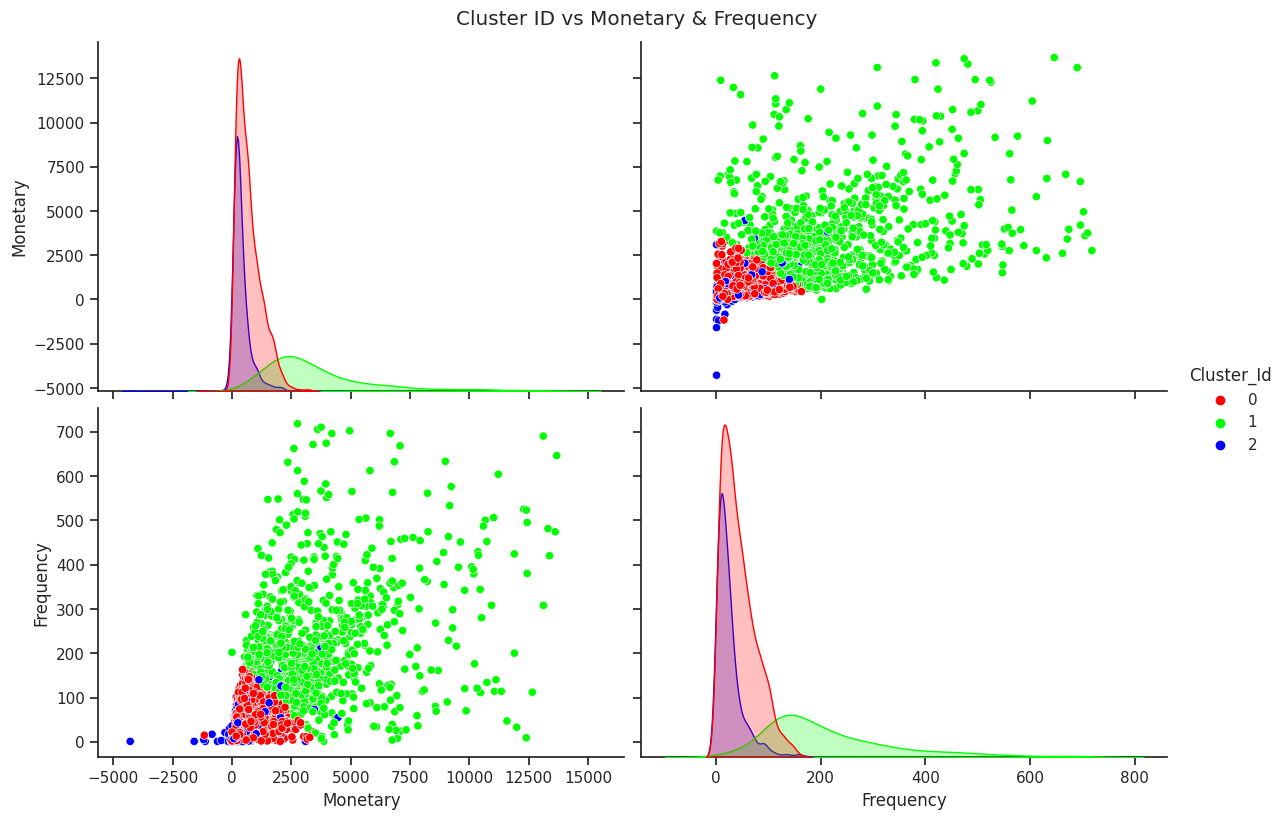

In [37]:
# Create a custom color palette with Red, Green, and Blue
custom_palette = sns.color_palette(["#FF0000", "#00FF00", "#0000FF"])

# Create a scatter plot matrix with separate plots for each cluster, custom palette, and a larger size
sns.set(style="ticks")
sns.pairplot(merged_rfm, hue='Cluster_Id', vars=['Monetary', 'Frequency'], palette=custom_palette, height=4, aspect=1.5)
plt.suptitle('Cluster ID vs Monetary & Frequency', y=1.02)
plt.show()

In [38]:
fig = px.box(merged_rfm, x='Cluster_Id', y='Frequency',
             title="Cluster Id vs Frequency Box Plot",
             labels={'Cluster_Id': 'Cluster ID', 'Frequency': 'Frequency'})

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="Frequency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [39]:
fig = px.box(merged_rfm, x='Cluster_Id', y='Recency',
             title="Cluster Id vs Recency Box Plot",
             labels={'Cluster_Id': 'Cluster ID', 'Recency': 'Recency'})

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="Recency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [40]:
# Selecting the two features for clustering
data_for_clustering = merged_rfm[['Monetary', 'Frequency']]

# Specify the number of clusters (e.g., 3)
n_clusters = 3

# Apply K-Medoids clustering
kmedoids = KMedoids(n_clusters=n_clusters)
merged_rfm['Cluster_2D'] = kmedoids.fit_predict(data_for_clustering)

# Create a scatter plot with Plotly
fig = px.scatter(merged_rfm, x='Monetary', y='Frequency', color='Cluster_2D',
                 title='Clustering by Monetary and Frequency',
                 labels={'Monetary': 'Monetary', 'Frequency': 'Frequency', 'Cluster_2D': 'Cluster'})

fig.update_layout(
    xaxis=dict(title="Monetary", title_font=dict(size=14)),
    yaxis=dict(title="Frequency", title_font=dict(size=14)),
    width=800,
    height=600
)

fig.show()

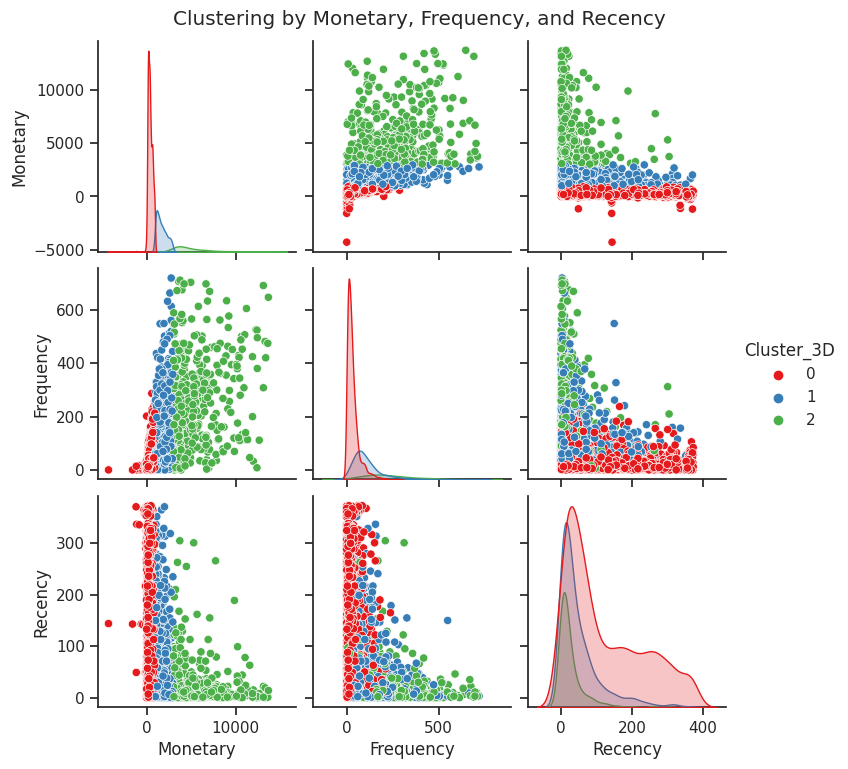

In [41]:
# Selecting the three features for clustering
data_for_clustering = merged_rfm[['Monetary', 'Frequency', 'Recency']]

# Apply K-Medoids clustering
kmedoids = KMedoids(n_clusters=n_clusters)
merged_rfm['Cluster_3D'] = kmedoids.fit_predict(data_for_clustering)

# Visualize the clusters (scatter plot matrix)
sns.set(style="ticks")
sns.pairplot(merged_rfm, hue='Cluster_3D', vars=['Monetary', 'Frequency', 'Recency'], palette='Set1')
plt.suptitle('Clustering by Monetary, Frequency, and Recency', y=1.02)
plt.show()

In [42]:
# Apply K-Medoids clustering
kmedoids = KMedoids(n_clusters=n_clusters)
merged_rfm['Cluster_3D'] = kmedoids.fit_predict(data_for_clustering)

# Create a 3D scatter plot matrix with Plotly
fig = px.scatter_3d(merged_rfm, x='Monetary', y='Frequency', z='Recency', color='Cluster_3D',
                     labels={'Monetary': 'Monetary', 'Frequency': 'Frequency', 'Recency': 'Recency', 'Cluster_3D': 'Cluster'})

fig.update_layout(
    scene=dict(
        xaxis_title='Monetary',
        yaxis_title='Frequency',
        zaxis_title='Recency',
    ),
    title='Clustering by Monetary, Frequency, and Recency',
    width=800,
    height=600
)

fig.show()

## Hierarchical Clustering

### Single Linkage

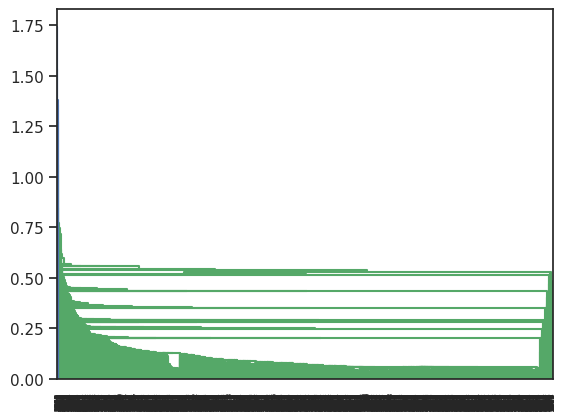

In [43]:
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

In [44]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [45]:
# Assign cluster labels

merged_rfm['Cluster_Labels'] = cluster_labels
merged_rfm.head()

Monetary  Frequency  Recency  Cluster_Id  Cluster_2D  Cluster_3D  \
0      0.00          2      325           2           2           0   
1   4310.00        182        1           1           1           2   
2   1797.24         31       74           0           0           1   
3   1757.55         73       18           0           0           1   
4    334.40         17      309           2           2           0   

   Cluster_Labels  
0               0  
1               0  
2               0  
3               0  
4               0

In [46]:
fig = px.box(merged_rfm, x='Cluster_Labels', y='Monetary',
             title="Cluster Labels vs Monetary Box Plot",
             labels={'Cluster_Labels': 'Cluster Labels', 'Monetary': 'Monetary'})

fig.update_layout(
    xaxis=dict(title="Cluster Labels", title_font=dict(size=14)),
    yaxis=dict(title="Monetary", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [47]:
fig = px.box(merged_rfm, x='Cluster_Labels', y='Frequency',
             title="Cluster Labels vs Frequency Box Plot",
             labels={'Cluster_Labels': 'Cluster Labels', 'Frequency': 'Frequency'})

fig.update_layout(
    xaxis=dict(title="Cluster Labels", title_font=dict(size=14)),
    yaxis=dict(title="Frequency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [48]:
fig = px.box(merged_rfm, x='Cluster_Labels', y='Recency',
             title="Cluster Labels vs Recency Box Plot",
             labels={'Cluster_Labels': 'Cluster Labels', 'Recency': 'Recency'})

fig.update_layout(
    xaxis=dict(title="Cluster Labels", title_font=dict(size=14)),
    yaxis=dict(title="Recency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

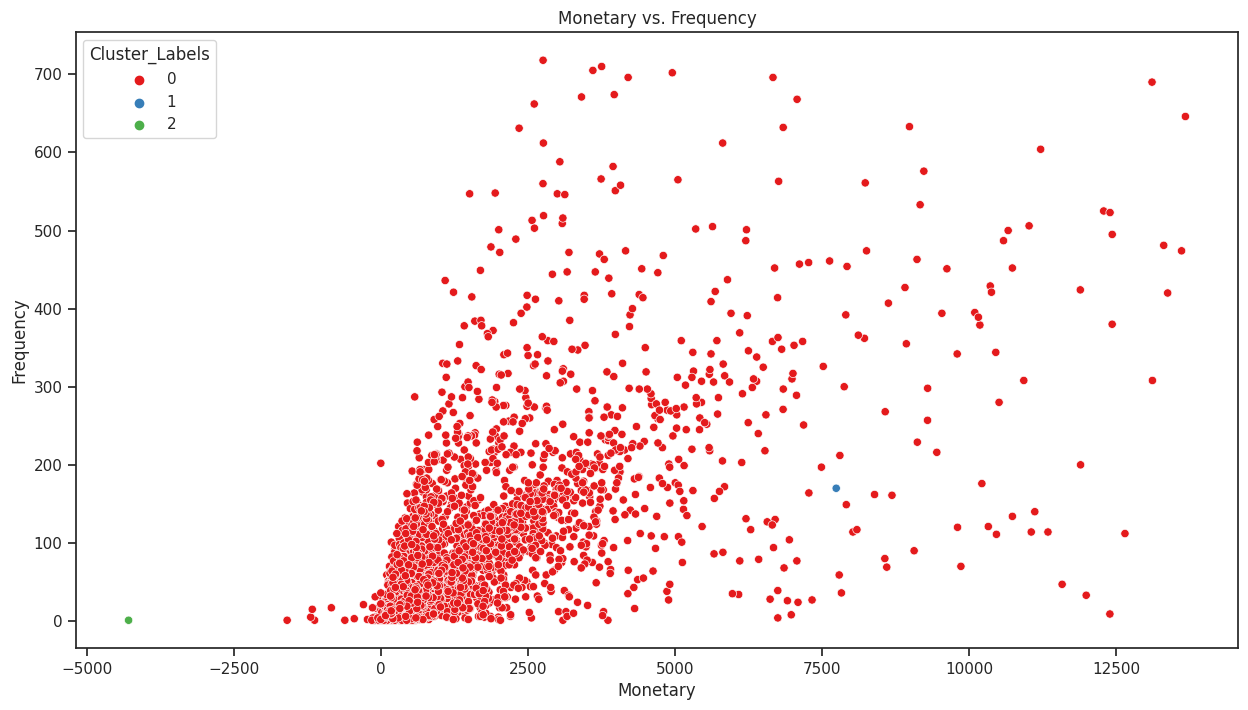

In [49]:
# Pairwise scatter plots for clustering (2D)
plt.figure(figsize=(15, 8))  # Adjust the figure size here

# Monetary vs. Frequency
sns.scatterplot(x='Monetary', y='Frequency', hue='Cluster_Labels', data=merged_rfm, palette='Set1')
plt.title('Monetary vs. Frequency');

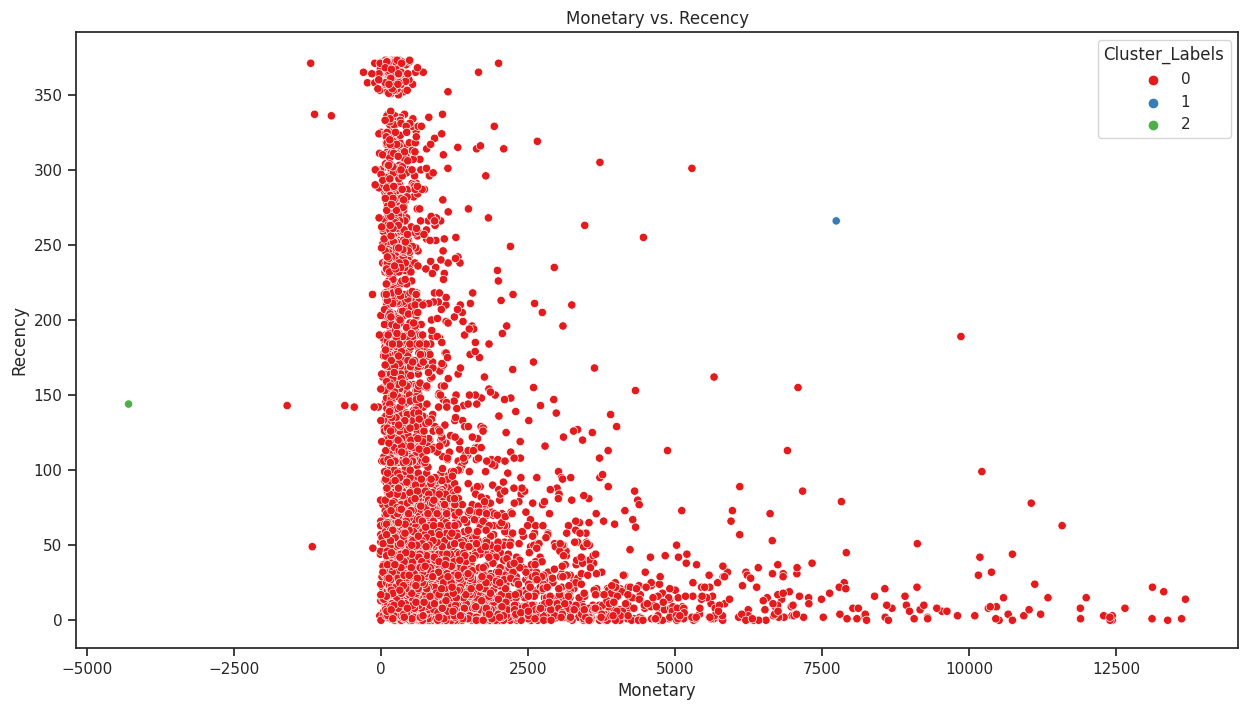

In [50]:
plt.figure(figsize=(15, 8))  # Adjust the figure size here

sns.scatterplot(x='Monetary', y='Recency', hue='Cluster_Labels', data=merged_rfm, palette='Set1')
plt.title('Monetary vs. Recency');

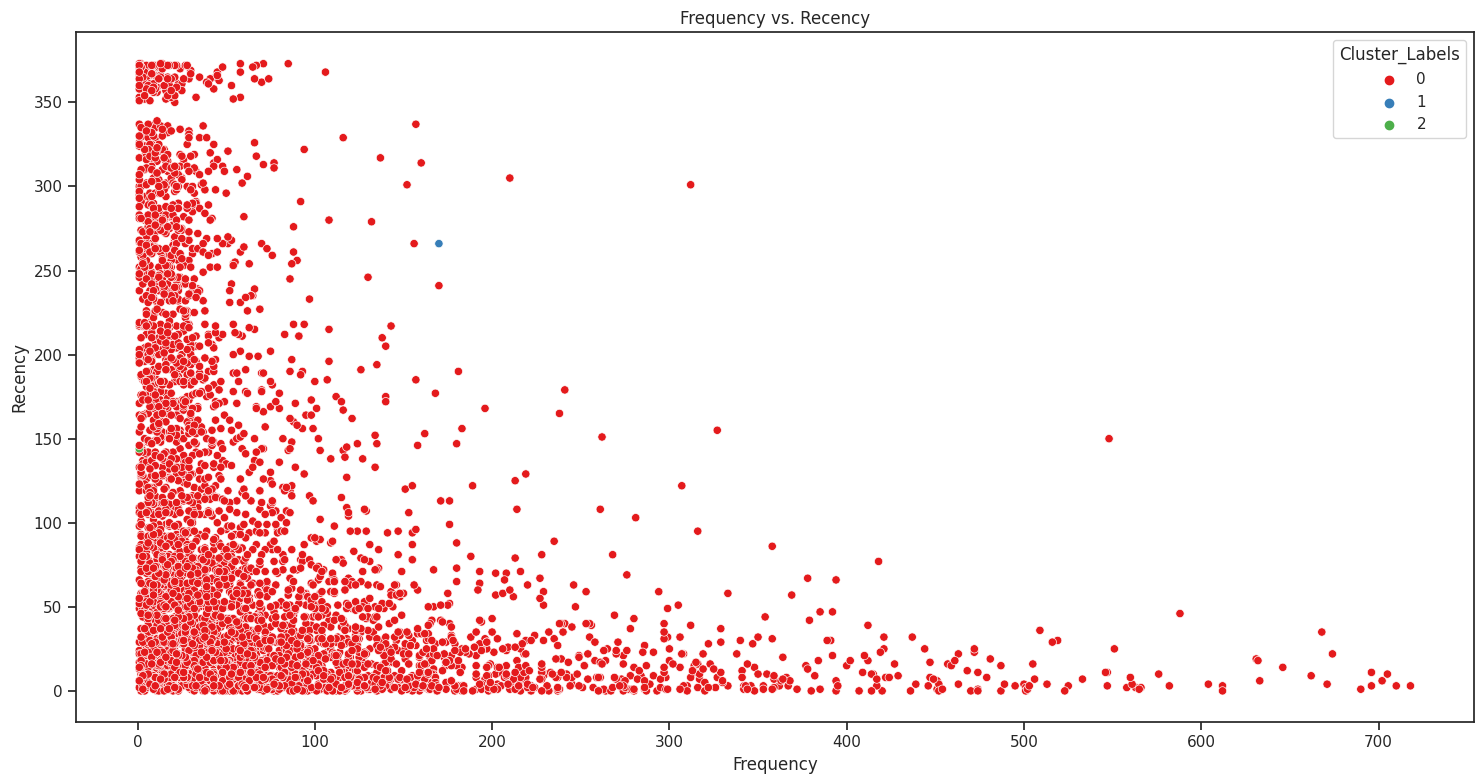

In [51]:
# Frequency vs. Recency
plt.figure(figsize=(15, 8))  # Adjust the figure size here
sns.scatterplot(x='Frequency', y='Recency', hue='Cluster_Labels', data=merged_rfm, palette='Set1')
plt.title('Frequency vs. Recency')

plt.tight_layout()
plt.show()

## Complete Linkage

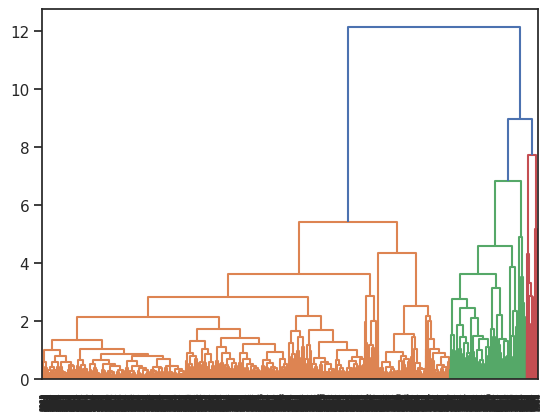

In [52]:
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [53]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [54]:
# Assign cluster labels

merged_rfm['Cluster_Labels'] = cluster_labels
merged_rfm.head()

Monetary  Frequency  Recency  Cluster_Id  Cluster_2D  Cluster_3D  \
0      0.00          2      325           2           2           0   
1   4310.00        182        1           1           1           2   
2   1797.24         31       74           0           0           1   
3   1757.55         73       18           0           0           1   
4    334.40         17      309           2           2           0   

   Cluster_Labels  
0               0  
1               1  
2               0  
3               0  
4               0

In [55]:
fig = px.box(merged_rfm, x='Cluster_Labels', y='Monetary',
             title="Cluster Labels vs Monetary Box Plot",
             labels={'Cluster_Labels': 'Cluster Labels', 'Monetary': 'Monetary'})

fig.update_layout(
    xaxis=dict(title="Cluster Labels", title_font=dict(size=14)),
    yaxis=dict(title="Monetary", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [56]:
fig = px.box(merged_rfm, x='Cluster_Labels', y='Frequency',
             title="Cluster Labels vs Frequency Box Plot",
             labels={'Cluster_Labels': 'Cluster Labels', 'Frequency': 'Frequency'})

fig.update_layout(
    xaxis=dict(title="Cluster Labels", title_font=dict(size=14)),
    yaxis=dict(title="Frequency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [57]:
fig = px.box(merged_rfm, x='Cluster_Labels', y='Recency',
             title="Cluster Labels vs Recency Box Plot",
             labels={'Cluster_Labels': 'Cluster Labels', 'Recency': 'Recency'})

fig.update_layout(
    xaxis=dict(title="Cluster Labels", title_font=dict(size=14)),
    yaxis=dict(title="Recency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

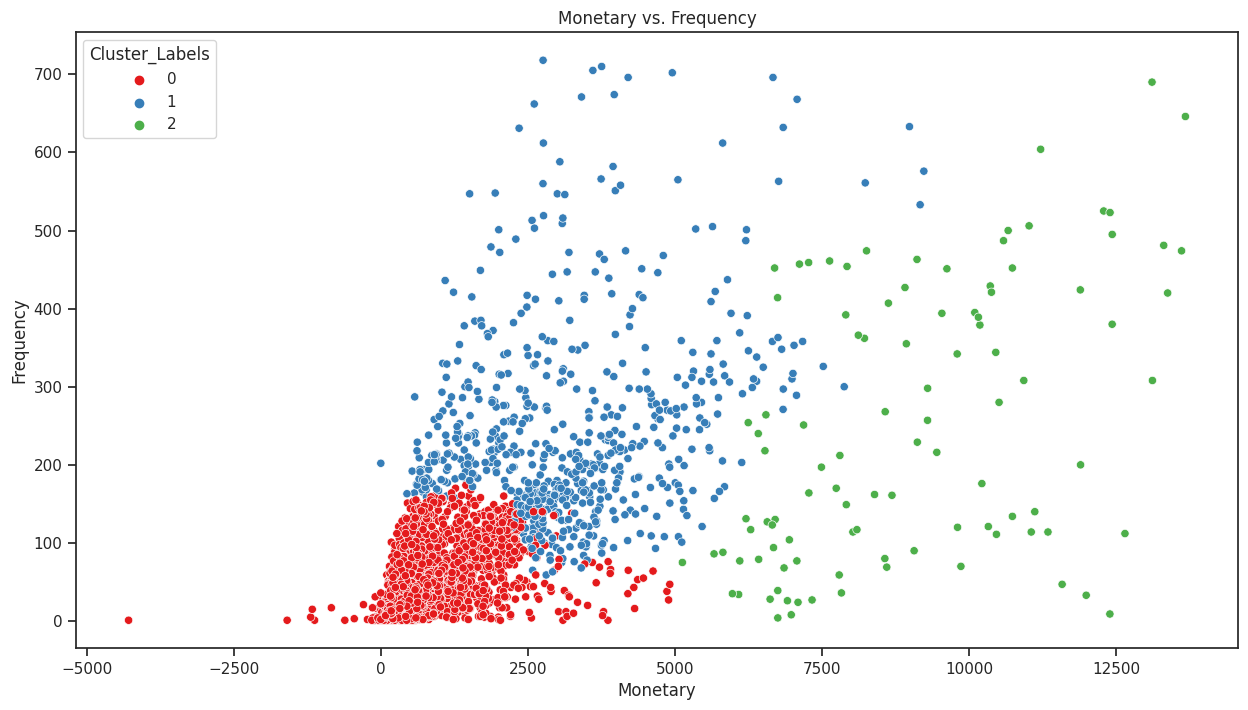

In [58]:
# Pairwise scatter plots for clustering (2D)
plt.figure(figsize=(15, 8))  # Adjust the figure size here

# Monetary vs. Frequency
sns.scatterplot(x='Monetary', y='Frequency', hue='Cluster_Labels', data=merged_rfm, palette='Set1')
plt.title('Monetary vs. Frequency');

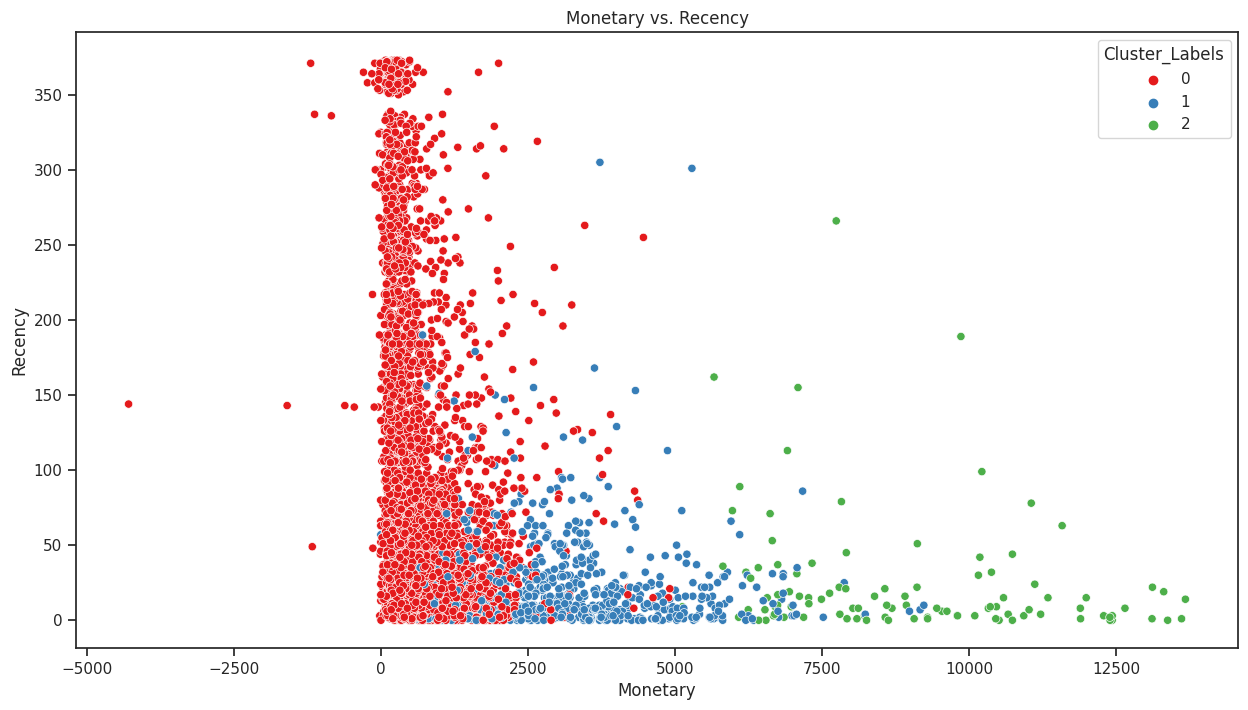

In [59]:
plt.figure(figsize=(15, 8))  # Adjust the figure size here

sns.scatterplot(x='Monetary', y='Recency', hue='Cluster_Labels', data=merged_rfm, palette='Set1')
plt.title('Monetary vs. Recency');

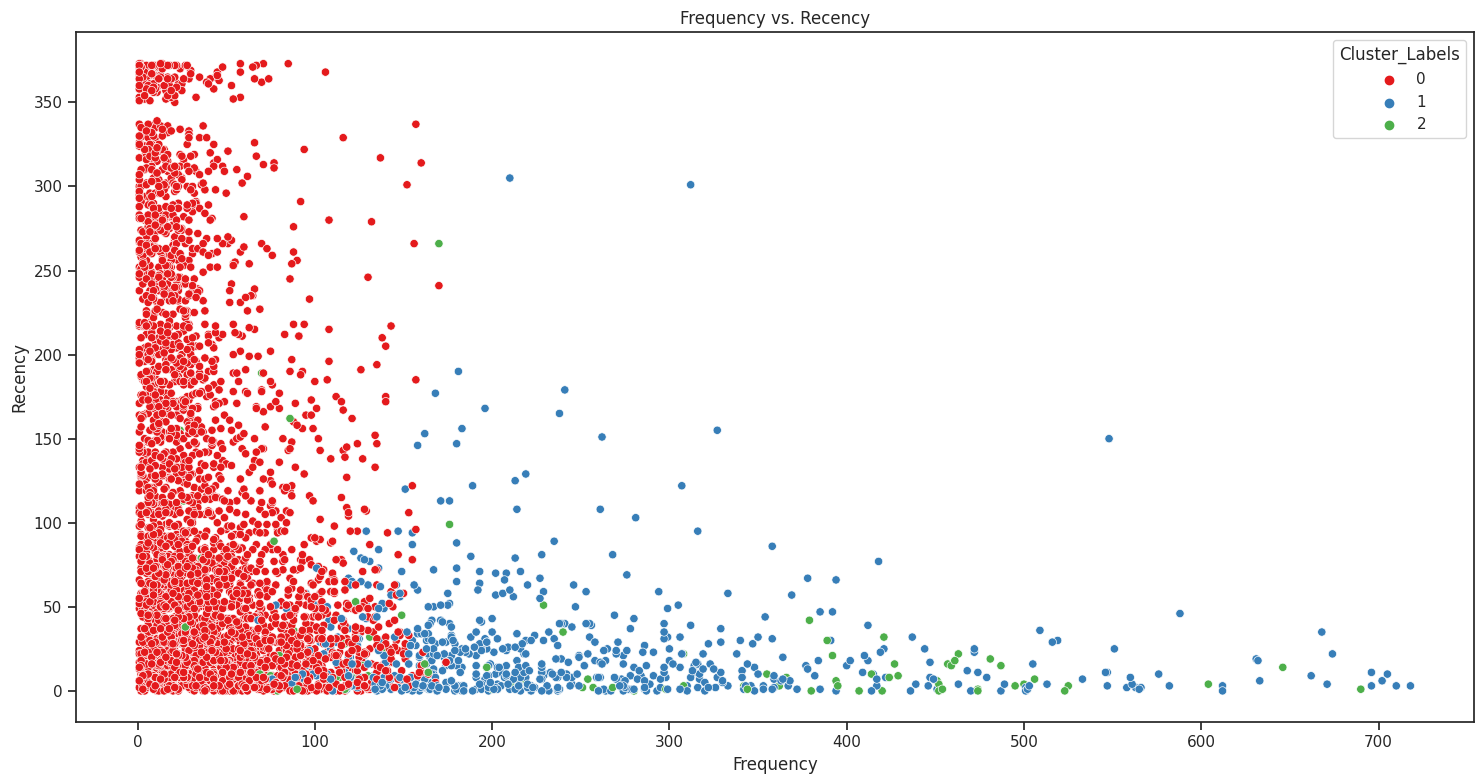

In [60]:
# Frequency vs. Recency
plt.figure(figsize=(15, 8))  # Adjust the figure size here
sns.scatterplot(x='Frequency', y='Recency', hue='Cluster_Labels', data=merged_rfm, palette='Set1')
plt.title('Frequency vs. Recency')

plt.tight_layout()
plt.show()

## Average Linkage

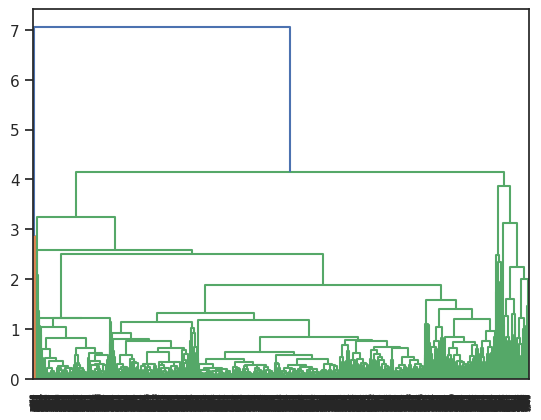

In [61]:
mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

In [62]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [63]:
# Assign cluster labels

merged_rfm['Cluster_Labels'] = cluster_labels
merged_rfm.head()

Monetary  Frequency  Recency  Cluster_Id  Cluster_2D  Cluster_3D  \
0      0.00          2      325           2           2           0   
1   4310.00        182        1           1           1           2   
2   1797.24         31       74           0           0           1   
3   1757.55         73       18           0           0           1   
4    334.40         17      309           2           2           0   

   Cluster_Labels  
0               0  
1               0  
2               0  
3               0  
4               0

In [64]:
fig = px.box(merged_rfm, x='Cluster_Labels', y='Monetary',
             title="Cluster Labels vs Monetary Box Plot",
             labels={'Cluster_Labels': 'Cluster Labels', 'Monetary': 'Monetary'})

fig.update_layout(
    xaxis=dict(title="Cluster Labels", title_font=dict(size=14)),
    yaxis=dict(title="Monetary", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [65]:
fig = px.box(merged_rfm, x='Cluster_Labels', y='Frequency',
             title="Cluster Labels vs Frequency Box Plot",
             labels={'Cluster_Labels': 'Cluster Labels', 'Frequency': 'Frequency'})

fig.update_layout(
    xaxis=dict(title="Cluster Labels", title_font=dict(size=14)),
    yaxis=dict(title="Frequency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [66]:
fig = px.box(merged_rfm, x='Cluster_Labels', y='Recency',
             title="Cluster Labels vs Recency Box Plot",
             labels={'Cluster_Labels': 'Cluster Labels', 'Recency': 'Recency'})

fig.update_layout(
    xaxis=dict(title="Cluster Labels", title_font=dict(size=14)),
    yaxis=dict(title="Recency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

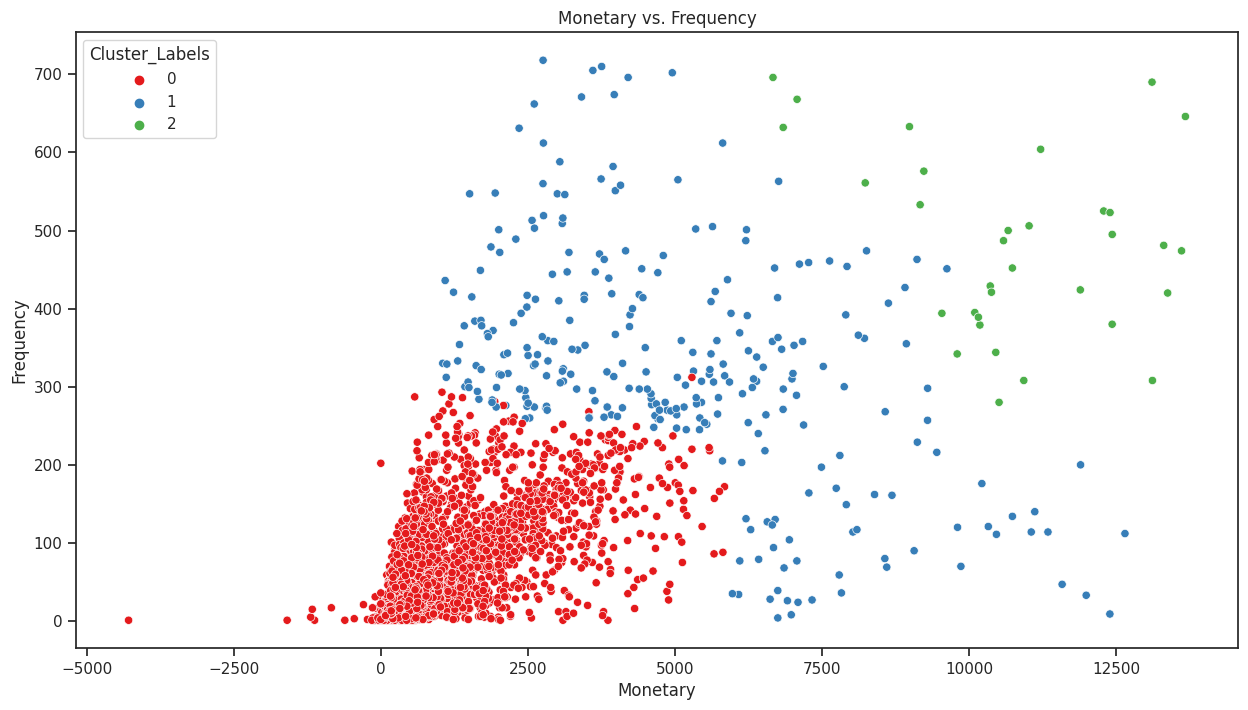

In [67]:
# Pairwise scatter plots for clustering (2D)
plt.figure(figsize=(15, 8))  # Adjust the figure size here

# Monetary vs. Frequency
sns.scatterplot(x='Monetary', y='Frequency', hue='Cluster_Labels', data=merged_rfm, palette='Set1')
plt.title('Monetary vs. Frequency');

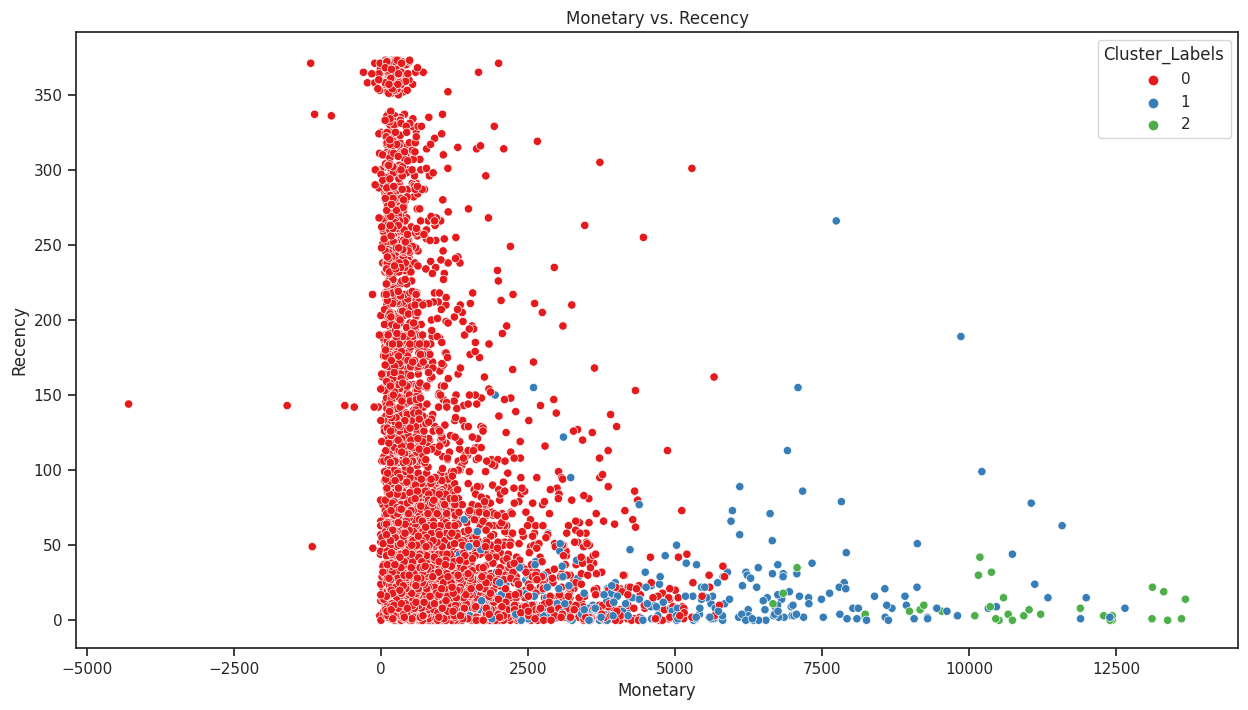

In [68]:
plt.figure(figsize=(15, 8))  # Adjust the figure size here

sns.scatterplot(x='Monetary', y='Recency', hue='Cluster_Labels', data=merged_rfm, palette='Set1')
plt.title('Monetary vs. Recency');

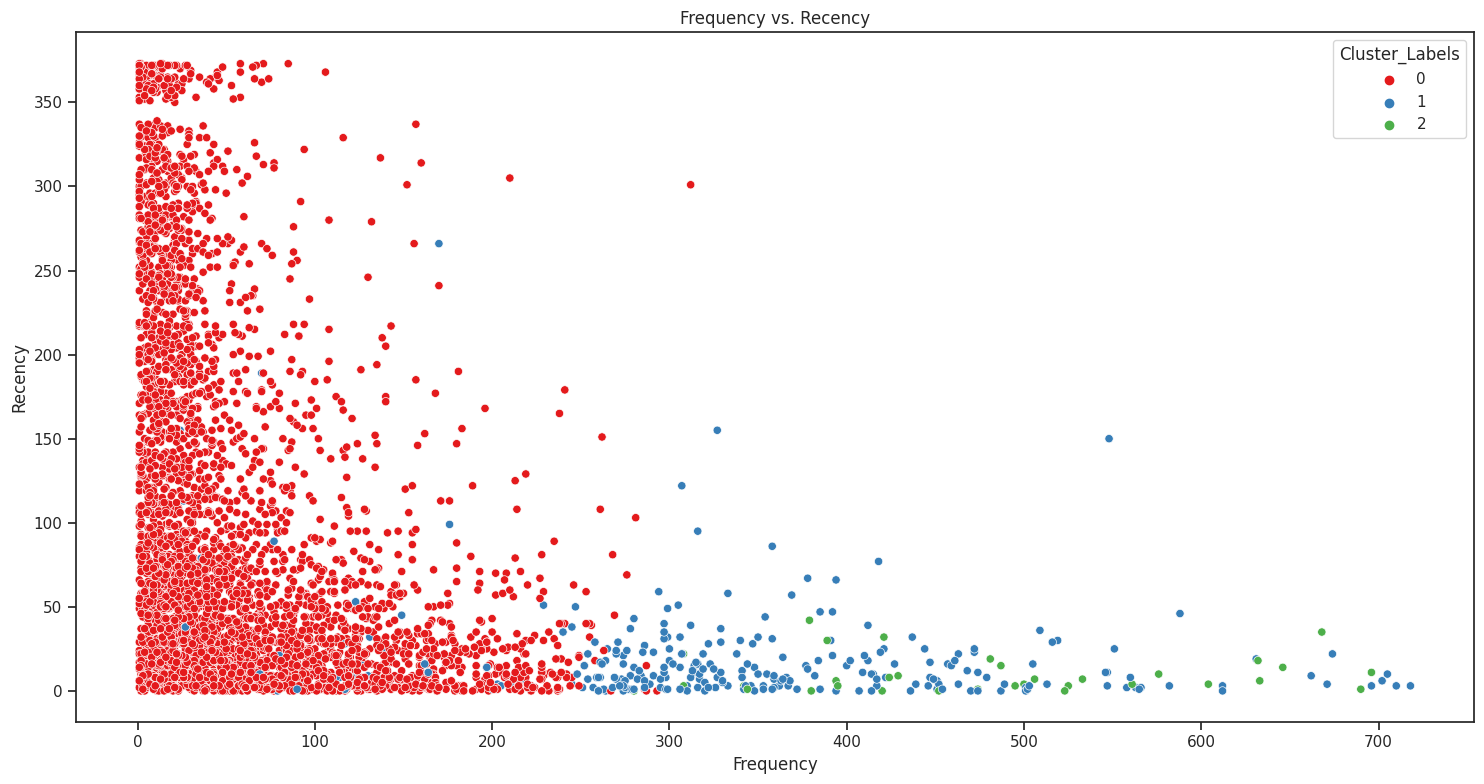

In [69]:
# Frequency vs. Recency
plt.figure(figsize=(15, 8))  # Adjust the figure size here
sns.scatterplot(x='Frequency', y='Recency', hue='Cluster_Labels', data=merged_rfm, palette='Set1')
plt.title('Frequency vs. Recency')

plt.tight_layout()
plt.show()